# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

Álvaro Chavarri, Daniel Ojeda, Carlos Vega y Lucía Gálvez

In [85]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [86]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min = 0
valor_max = 255
valores_color = 3
num_colores = 100
# creamos la matriz por separado
datos = np.random.randint(valor_min, valor_max, (num_colores, valores_color))

## SOM Setup
#### Variables definidas por el alumno

In [87]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 20
periodo = 10000
learning_rate = 0.02 
normalizar_datos = 'true'

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [88]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = len(datos)
num_datos = len(datos[0])

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario_inicial = lado_mapa/2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos == 'true':
    datosN = (datos-np.min(datos))/(np.max(datos)-(np.min(datos)))
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
m_pesos = np.random.random((lado_mapa, lado_mapa, valores_color))

#### Funciones para entrenar/clasificar

In [89]:
def distancia_euclidea(array1, array2):
    distancia = 0
    for i in range(0, array1.shape[0]):
            distancia = distancia + (array1[i] - array2[i]) ** 2
    return distancia

##### Calcular BMU
Esta función encuentra la neurona ganadora, calculando la distancia Euclídea neurona-patrón y guardando las coordenadas en la BMU (bmu_idx) 

In [90]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, num_entradas):
    #inicializamos la distancia minina
    dMin = np.iinfo(np.int).max
    #recorremos la matriz de pesos
    for x in range (m_pesos.shape[0]): #para x
        for y in range (m_pesos.shape[1]): #para y
            w = m_pesos[x, y] #vector de pesos
            dEuclidea = np.sqrt(np.sum((w - patron_entrada)** 2)) #distancia Euclidea
            if dEuclidea < dMin:
                dMin = dEuclidea
                bmu_idx = np.array([x, y])
    #vector de pesos de la neurona ganadora
    bmu = m_pesos[bmu_idx[0], bmu_idx[1]]
    return (bmu, bmu_idx)


In [91]:
def calcular_segunda_bmu(patron_entrada, m_pesos, num_entradas, coordenadas_bmu):
   
    # Inicializamos las variables.
    bmu_idx = np.array([0, 0])
    bmu = np.array([None, None, None])
    distancia = None
    
    # Calculamos la distancia entre el patrón de entrada y cada una de las neuronas existentes en la capa.    
    for x in range(0,m_pesos.shape[0]):
        for y in range(0,m_pesos.shape[1]):
            # Guardamos la matriz de pesos.
            w = m_pesos[x][y]
            coordenadas2 = [x, y]
            dEuclidea=0
            # Calculamos la distancia euclídea.
            dEuclidea = np.sqrt(np.sum((w - patron_entrada)** 2))

            # Comprobamos si la distancia entre neuronas es menor que la distancia euclidea calculada, para encontrar la segunda
            #ganadora.
            if distancia == None or dEuclidea < distancia: 
                if np.array_equal(coordenadas2, coordenadas_bmu) == False:
                    distancia = dEuclidea
                    bmu = w
                    bmu_idx = np.array([x, y])
                    
    return (bmu, bmu_idx) 

##### Variación learning rate
Esta función calcula eta para la i-ésima iteración

In [92]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(learning_rate, i, periodo):
    learning_rateV = learning_rate * (1-(i/periodo))
    return learning_rateV

##### Variación vecindario
Esta función calcula el desdenso del vecindario

In [93]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, periodo):
    lvecindario = 1 + vecindario_inicial * (1-(i/periodo))
    return lvecindario

##### Decay
Esta función calcula eta en función de la distancia a la BMU

In [94]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

Esta función nos permite pintar la matriz de los valores con los colores RGB

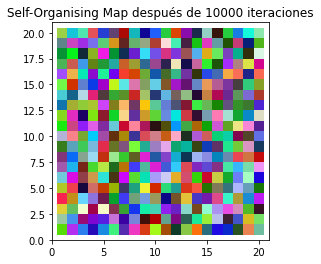

In [95]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, m_pesos.shape[0]+1))
    ax.set_ylim((0, m_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()
    
pintar_mapa(m_pesos)

Funcion para generar el histograma del mapa de activacion

In [96]:
def histograma3d(datos):
    %matplotlib inline
    
    fig2 = plt.figure()
    ax = Axes3D(fig2)
    
    # Trabajamos con los datos de la matriz data. Para ello establecemos una malla de posiciones bidimensionales
    
    lenx= len(datos[0])            
    leny= len(datos[:,0])
    xpos = np.arange(0,lenx,1)    
    ypos = np.arange(0,leny,1)
    xpos, ypos = np.meshgrid(xpos+1, ypos+1)

    # A partir de las longitudes de las x(filas) e y(columnas), generamos una z, que hara referencia al numero de activaciones.
    #y nos permitirá generar el histograma 3D
    
    xpos = xpos.flatten()   
    ypos = ypos.flatten()
    zpos = np.zeros(lenx*leny)
    #Generaremos una nueva matriz de mismo tamaño que las posiciones del numero de activaciones con la funcion ones like
    datosx = 0.5 * np.ones_like(zpos)
    datosy = datosx.copy()
    datosz = datos.flatten()

    cs= sns.color_palette("GnBu_d", lado_mapa)*leny
    ax.bar3d(xpos,ypos,zpos, datosx, datosy, datosz, color=cs)

    ax.set_xlabel('Filas')
    ax.set_ylabel('Columnas')
    ax.set_zlabel('Nº de activaciones')

    plt.show()

## SOM Entrenamiento

#### Creación del bucle para entrenar la red

In [97]:
# Entrena la red con el dataset de entrenamiento
for i in range(periodo):
    if i % 100 == 0: #cada 100 iteraciones imprimimos el número correspondiente
        print('Iteración: ', i)
    #patrón de entrada escogido al azar y convertido al formato de m_pesos
    patron_entrada = datosN[np.random.randint(datos.shape[0])] 
    #buscamos la BMU
    bmu, bmu_idx = calcular_bmu(patron_entrada, m_pesos, num_entradas)
    #calculamos eta y el vecindario correspondientes a la iteración i
    eta = variacion_learning_rate(learning_rate, i, periodo)
    v = variacion_vecindario(vecindario_inicial, i, periodo)

    #actualizamos el vector de pesos y así nos acercamos al patrón
    for x in range(lado_mapa):
        for y in range(lado_mapa):
            w = m_pesos[x, y] #actualizamos el vector de pesos
            #calculamos la distancia euclídea para cada neurona y acercarnos a la correspondiente
            distEuclidea = np.sqrt(np.sum((np.array([x,y]) - bmu_idx)**2))
            if distEuclidea <= vecindario_inicial: #si la distancia euclidea es menor o igual que el vecindario
                #calculamos la amortigüación 
                amortiguacion = decay(distEuclidea, v)
                #actualizamos el vector de pesos de la neurona
                m_pesos[x, y] = w + eta * amortiguacion * (patron_entrada - w)

m_pesos

Iteración:  0
Iteración:  100
Iteración:  200
Iteración:  300
Iteración:  400
Iteración:  500
Iteración:  600
Iteración:  700
Iteración:  800
Iteración:  900
Iteración:  1000
Iteración:  1100
Iteración:  1200
Iteración:  1300
Iteración:  1400
Iteración:  1500
Iteración:  1600
Iteración:  1700
Iteración:  1800
Iteración:  1900
Iteración:  2000
Iteración:  2100
Iteración:  2200
Iteración:  2300
Iteración:  2400
Iteración:  2500
Iteración:  2600
Iteración:  2700
Iteración:  2800
Iteración:  2900
Iteración:  3000
Iteración:  3100
Iteración:  3200
Iteración:  3300
Iteración:  3400
Iteración:  3500
Iteración:  3600
Iteración:  3700
Iteración:  3800
Iteración:  3900
Iteración:  4000
Iteración:  4100
Iteración:  4200
Iteración:  4300
Iteración:  4400
Iteración:  4500
Iteración:  4600
Iteración:  4700
Iteración:  4800
Iteración:  4900
Iteración:  5000
Iteración:  5100
Iteración:  5200
Iteración:  5300
Iteración:  5400
Iteración:  5500
Iteración:  5600
Iteración:  5700
Iteración:  5800
Iteración

array([[[0.17430732, 0.73556052, 0.17511702],
        [0.17576329, 0.71402854, 0.18555971],
        [0.18037518, 0.68006855, 0.20035392],
        ...,
        [0.40116361, 0.11861392, 0.6515851 ],
        [0.40779254, 0.11873989, 0.68768277],
        [0.41415162, 0.12095501, 0.72180249]],

       [[0.19472206, 0.74894064, 0.17140274],
        [0.19204177, 0.72383181, 0.18115075],
        [0.19600997, 0.69159379, 0.19536169],
        ...,
        [0.40935991, 0.12895978, 0.67715966],
        [0.41937674, 0.1296201 , 0.71531976],
        [0.42509591, 0.13290368, 0.74586247]],

       [[0.22142298, 0.75303487, 0.16926664],
        [0.22098292, 0.73021398, 0.17918876],
        [0.2242757 , 0.69821835, 0.1935515 ],
        ...,
        [0.419465  , 0.14673028, 0.70913104],
        [0.43007816, 0.14637588, 0.74670339],
        [0.43657249, 0.14784962, 0.772364  ]],

       ...,

       [[0.81885527, 0.4046189 , 0.23999714],
        [0.82274243, 0.39327178, 0.26549089],
        [0.82262057, 0

Pintamos la matriz de pesos con la función definida anteriormente 'pintar_mapa()'

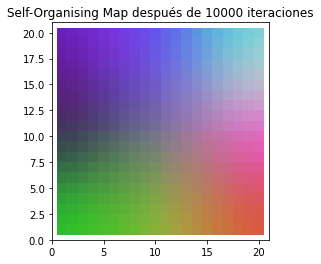

In [98]:
pintar_mapa(m_pesos)

## SOM Clasificación

### Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada

#### Definimos e inicializamos las tres matrices
##### Mapa de Clasificación: mClasificacion 
Es una matriz con las mismas dimensiones que m_pesos y guarda en cada neurona el último patron clasificado
##### Mapa de Activación: mActivacion
Es una matriz bidimensional que guarda el número de patrones reconocido por  cada neurona
##### Mapa de Distancias: mDistancias
Es una matriz bidimensional que guarda las neuronas con activación>0

In [99]:
mClasificacion = np.zeros((lado_mapa, lado_mapa, valores_color))                          
mActivacion = np.zeros((lado_mapa, lado_mapa))
mDistancias = np.zeros((lado_mapa, lado_mapa))
distancia_media = 0
distanciaEuclidea = 0
contAct = 0
homogeneidad = 0

#### Recorremos todo el dataset de entrenamiento

##### Imprimimos las coordenadas x e y de la BMU para cada patrón de prueba

In [104]:
for i in range (0, num_colores):
    bmu,bmu_idx= calcular_bmu(datosN[i], m_pesos, num_entradas)
    #bmu2 = calcular_segunda_bmu(datosN[i], m_pesos, num_entradas, bmu[1])
    #if distancia_euclidea(bmu[1], bmu2[1]) > 2:
        #homogeneidad += 1
    #actualizamos el mapa de clasificación, añadiendo el patrón en la neurona que lo ha reconocido
    mClasificacion[bmu_idx[0], bmu_idx[1]] = datosN[i]
    distanciaEuclidea = np.sqrt(np.sum((bmu - datosN[i])**2)) #calculamos la distancia euclidea
    mDistancias[bmu_idx[0], bmu_idx[1]] =+ distanciaEuclidea
    #actualizamos el mapa de activación, +1 en las activaciones
    mActivacion[bmu_idx[0], bmu_idx[1]] =+ 1
    print('Coordenadas BMU:', datosN[i])
    print('X = ', bmu_idx[0])
    print('Y = ', bmu_idx[1])  

# Sacamos la distancia media de cada neurona a partir del número de activaciones.
for i in range(0,lado_mapa):
    for j in range(0,lado_mapa): 
        if mActivacion[i-1][j-1] != 0:
            mDistancias[i-1][j-1]=mDistancias[i-1][j-1] / mActivacion[i-1][j-1]
            
            # Calculamos la distancia media total.
            distancia_media += mDistancias[i-1][j-1]
            contAct +=1

# Contabilizamos el número de clases.
distancia_media=distancia_media/contAct

Coordenadas BMU: [0.12992126 0.11023622 0.37795276]
X =  0
Y =  10
Coordenadas BMU: [0.28740157 0.09448819 0.48031496]
X =  0
Y =  13
Coordenadas BMU: [0.29133858 0.13779528 0.60629921]
X =  2
Y =  14
Coordenadas BMU: [0.88976378 0.57480315 0.25590551]
X =  15
Y =  0
Coordenadas BMU: [0.50393701 0.28740157 0.77559055]
X =  7
Y =  15
Coordenadas BMU: [0.75984252 0.85433071 0.31889764]
X =  11
Y =  0
Coordenadas BMU: [0.61417323 0.68110236 0.82677165]
X =  16
Y =  15
Coordenadas BMU: [0.95669291 0.05511811 0.7007874 ]
X =  19
Y =  7
Coordenadas BMU: [0.42913386 0.97244094 0.86614173]
X =  18
Y =  19
Coordenadas BMU: [0.32677165 0.48031496 0.95275591]
X =  11
Y =  19
Coordenadas BMU: [0.41732283 0.52755906 0.31102362]
X =  7
Y =  6
Coordenadas BMU: [0.6023622  0.25984252 0.92913386]
X =  6
Y =  19
Coordenadas BMU: [0.96456693 0.31496063 0.12598425]
X =  19
Y =  0
Coordenadas BMU: [0.90944882 0.96062992 0.92519685]
X =  19
Y =  15
Coordenadas BMU: [0.37401575 0.05511811 0.56692913]
X =  0


##### Calculamos los mapas de clasificación, activación, y distancias

Mapa de Clasificación


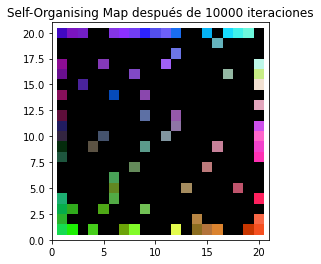


Mapa de Activación


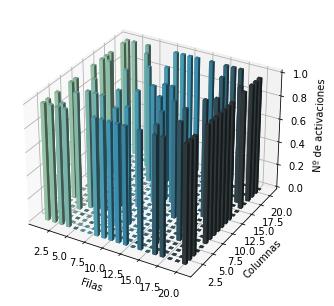

[[1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [105]:
print('Mapa de Clasificación')
pintar_mapa(mClasificacion)
print('\nMapa de Activación')
histograma3d(mActivacion)
print(mActivacion)
print('\nMapa de Distancias')
print(mDistancias)

##### Calculamos el número de clases

In [106]:
num_clases = np.count_nonzero(mActivacion)
print('Número de clases: ', num_clases)

Número de clases:  74


##### Calculamos el Error de Cuantificación y el Error Topológico del mapa

In [107]:
#error de cuantificación
eCuantificacion = (np.sum(mDistancias))/(np.sum(mActivacion))
print('Error de Cuantificación: ', eCuantificacion)


Error de Cuantificación:  0.15791347896053146


In [108]:
def error_topologico(N, homogeneidad):
    return 1/N*homogeneidad
print('Error Topológico: ', error_topologico(contAct, homogeneidad))
#Sigue dando 0, porque en la clasificacion me da un error de tuples, a ver si podeis sacarlos vosotros, he comentado el codigo
#que deberia de funcionar

Error de Cuantificación:  0.0


## SOM Prueba

Color clasificado en la coordenada: (19,14)
Colores clasificados: 


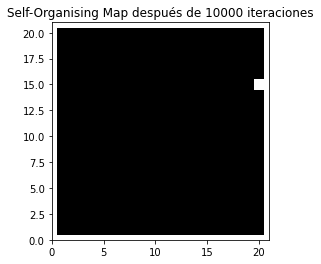

Color clasificado en la coordenada: (19,0)
Colores clasificados: 


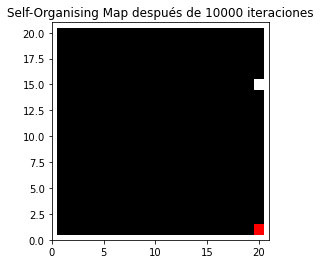

Color clasificado en la coordenada: (1,0)
Colores clasificados: 


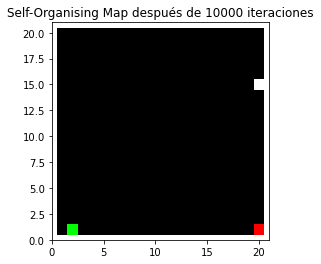

Color clasificado en la coordenada: (1,19)
Colores clasificados: 


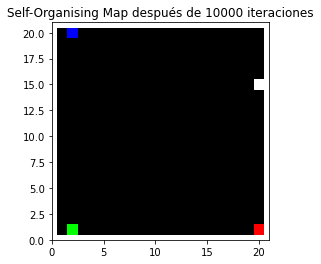

Color clasificado en la coordenada: (11,0)
Colores clasificados: 


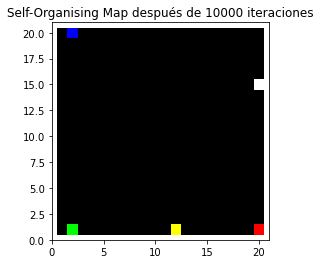

Color clasificado en la coordenada: (16,19)
Colores clasificados: 


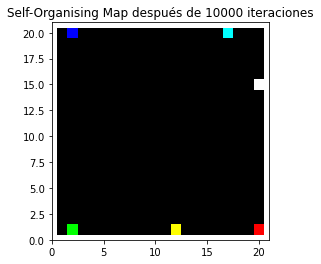

In [111]:
# Clasifica nuevos patrones
patrones = np.array([[255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255]])
mapa_k = np.copy(m_pesos) *0

# Inicializamos la matriz de pesos para la clasificacion de los nuevos patrones.
m_clasificacion = np.copy(m_pesos) *0

for i in range(0, patrones.shape[0]):
    
    # Guardamos los colores en la matriz de patrones.
    color=patrones[i]
    #Calculamos la BMU
    bmu, bmu_idx= calcular_bmu((color/valor_max),m_pesos, num_entradas)
    
    # Una vez obtenida la BMU correspondiente, clasificamos los colores.
    mapa_k[bmu_idx[0]][bmu_idx[1]] = bmu[0]
    m_clasificacion[bmu_idx[0]][bmu_idx[1]] = (color/valor_max)
    print("Color clasificado en la coordenada: ("+str(bmu_idx[0])+","+str(bmu_idx[1])+")")
    
    # Imprimimos el mapa de colores primarios ya clasificados.
    print("Colores clasificados: ")
    pintar_mapa(m_clasificacion)